# II) Méthodes du projet

## Méthodes pour le nettoyage des données

In [1]:
# pour filtrer les colonnes en fonction de leur taux de valeurs manquantes
def filter_col_by_mising_data_pct(df, pct_min=0, pct_max=100):
    result = pd.DataFrame()
    print("Le DataFrame à filtrer présente", len(df), "lignes et", len(df.columns), "colonnes.")
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de", pct_min, "% inclu à", pct_max, "% exclu.")
    # extraction des colonnes remplissant la condition de filtrage
    tot_list_col = round(df.isnull().mean()*100, 4).sort_values(ascending=False)
    tot_list_col = pd.DataFrame(tot_list_col, columns = ["%"])
    remain_list_col = tot_list_col.loc[(tot_list_col["%"] >= pct_min) & (tot_list_col["%"] < pct_max), :]
    nb_col_remained = len(remain_list_col)
    nb_col_removed = len(tot_list_col) - nb_col_remained
    print("Après filtrage, il reste", nb_col_remained, "colonnes dans le DataFrame.")
    print("Il y a eu suppression de", nb_col_removed, "colonnes, soit", round(nb_col_removed/len(tot_list_col)*100, 2), "% des colonnes.")
    
    # test sur le nb de colonnes restantes
    if len(remain_list_col) == 0:
        print("Le filtre est trop bas. Il n'y a plus de colonnes à exploiter.")
        return result
    
    # renvoyer le même dataset avec uniquement les colonnes filtrées
    result = df[remain_list_col.index]
    return result

In [2]:
# pour supprimer les colonnes vides en passant par la méthode de filtre en fonction du taux de valeurs manquantes
def remove_empty_columns(df):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.")
    result = filter_col_by_mising_data_pct(df)
    return result    

In [3]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

## Méthodes pour l'ACP

In [4]:
# pour utiliser la méthode du PCA et afficher l'éboulis des inerties entre les variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def compute_pca(df, n_components=2):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    # split des données
    X = df.values
    names = df.index
    features = df.columns
    
    print("L'échantillon présente", df.shape[0], "lignes et", df.shape[1], "colonnes")
    # vérif n_components
    if n_components > min(len(df), len(features)):
        print("Le nombre de composantes est trop élevée. On le recale à la valeur maximale.")
        print("La nouvelle valeur sera le minimum entre le nombre de ligne dans l'échantillon et le nombre de features, càd", min(len(df), len(features)))
        n_components = min(len(df), len(features))
    
    scaler = StandardScaler() # instance de scaler
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components) # instance de PCA
    pca.fit(X_scaled) # entrainement sur les données scalées
    
    # print("Valeurs propres (mieux si > 1):", pca.explained_variance_)
    print("Une méthode consiste à dire que l'on garde uniquement les valeurs propres supérieures à 1.")
    nb_opti_val_p = [x for x in pca.explained_variance_ if x >= 0.9]
    print("Ici, la méthode des valeurs propres nous demande de garder", len(nb_opti_val_p), "composantes.")
    # print("Variance ratio", pca.explained_variance_ratio_)
    
    # tracé de l'éboulis des valeurs propres
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    print("La méthode principale consiste à dire que l'on garde uniquement les composantes qui regroupent 95% des variables.")
    nb_opti_95_inertie = len([x for x in scree_cum if x <= 95])
    print("Ici, la méthode des 95% d'inertie nous demande de garder", nb_opti_95_inertie, "composantes.")
    
    x_list = range(1, n_components+1)
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker='o')
    plt.xticks(np.arange(0, n_components+1, 2))
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    
    # pour afficher les lignes de 95% et de nombre de composantes optimal
    min_ylim, max_ylim = plt.ylim()
    min_xlim, max_xlim = plt.xlim()
    plt.axvline(nb_opti_95_inertie, color='k', linestyle='dashed', linewidth=1)
    plt.text(nb_opti_95_inertie, max_ylim*0.85, ' {:.0f} composantes'.format(nb_opti_95_inertie))
    plt.axhline(95, color='k', linestyle='dashed', linewidth=1)
    plt.text(max_xlim*0.55, 95+2, "95 % d'inertie")
    
    plt.show(block=False)
    
    return pca

In [5]:
def show_components_heatmap(df, pca):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = df.columns # features
    n_components = len(pcs)
    x_list = range(1, n_components+1)
    pcs.index = [f"F{i}" for i in x_list]
    pcs.round(2)
    # représentation visuelle
    gif, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
    return pcs


In [6]:
def compute_components(pcs, threshold=0.6):
    result = []
    for index, row in pcs.iterrows():
        for col in pcs.columns:
            if abs(row[col]) >= threshold:
                print(col, ":", row[col])
                result.append(col)
    
    result = list(set(result))
    print("Il y a", len(result), "variables ayant un impact conséquent sur les composantes.")
    print("Voici la liste :", result)
    return result

## Méthode pour ANOVA

In [7]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

## Méthode pour affichage personnalisé

In [8]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

***
# III) Présentation générale du jeu de données

## 1) Exploration du dataset

### a) Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

### b) Chargement du dataset

In [10]:
print(os.listdir("input/"))

['olist_products_dataset.csv', 'olist_order_items_dataset.csv', 'olist_orders_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_customers_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_sellers_dataset.csv', 'olist_order_payments_dataset.csv']


In [11]:
full_data = {}
for file_name in os.listdir("input/"):
    full_data[file_name] = pd.read_csv("input/" + file_name, encoding='utf-8', sep=',')

In [12]:
for file_name, sub_data in full_data.items():
    print(file_name, ", Shape :", sub_data.shape)
    display(sub_data.describe())
    display(sub_data.head())

olist_products_dataset.csv , Shape : (32951, 9)


,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


olist_order_items_dataset.csv , Shape : (112650, 7)


,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


olist_orders_dataset.csv , Shape : (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


olist_geolocation_dataset.csv , Shape : (1000163, 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


olist_customers_dataset.csv , Shape : (99441, 5)


,customer_zip_code_prefix
count,99441.000000
mean,35137.474583
std,29797.938996
min,1003.000000
25%,11347.000000
50%,24416.000000
75%,58900.000000
max,99990.000000


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


olist_order_reviews_dataset.csv , Shape : (99224, 7)


,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


olist_sellers_dataset.csv , Shape : (3095, 4)


,seller_zip_code_prefix
count,3095.000000
mean,32291.059451
std,32713.453830
min,1001.000000
25%,7093.500000
50%,14940.000000
75%,64552.500000
max,99730.000000


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


olist_order_payments_dataset.csv , Shape : (103886, 5)


,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


# Test customers geolocalisation

In [13]:
data_customers = pd.read_csv("input/olist_customers_dataset.csv", encoding='utf-8', sep=',')

In [14]:
data_geo = pd.read_csv("input/olist_geolocation_dataset.csv", encoding='utf-8', sep=',')

In [15]:
data_customers_geo = data_customers.join(data_geo, how='left', on='customer_zip_code_prefix')

In [16]:
data_customers_geo.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1419,-23.560771,-46.659250,sao paulo,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1318,-23.556276,-46.640913,sao paulo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1019,-23.552391,-46.629603,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1322,-23.563000,-46.643791,sao paulo,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1403,-23.564542,-46.649343,sao paulo,SP


In [17]:
data_customers_geo.apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

customer_id                    99441
customer_unique_id             96096
customer_zip_code_prefix       14994
geolocation_lng                11685
geolocation_lat                11674
customer_city                   4119
geolocation_zip_code_prefix     1987
customer_state                    27
geolocation_city                   3
geolocation_state                  2
dtype: int64

In [18]:
data_num, data_categ = split_data_num_categ(data_customers_geo)

Voici la répartition des colonnes par type de données :
numeric : 4 colonnes.
category : 6 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [19]:
# import plotly.express as px
# fig = px.density_mapbox(data_customers_geo,
# lat='geolocation_lat', lon='geolocation_lng',
# hover_data=['geolocation_city', 'customer_city'],
# radius=2, zoom=11,
# mapbox_style="open-street-map",
# # title="Localisation des grands arbres sur une carte de Paris.",
# width=1300, height=1100,)
# fig.show()

In [20]:
# import plotly.express as px
# fig = px.density_mapbox(data_geo,
# lat='geolocation_lat', lon='geolocation_lng',
# hover_data=['geolocation_city'],
# radius=2, zoom=20,
# mapbox_style="open-street-map",
# # title="Localisation des grands arbres sur une carte de Paris.",
# width=1300, height=1100,)
# fig.show()

# Test customers orders

In [21]:
data_customers = pd.read_csv("input/olist_customers_dataset.csv", encoding='utf-8', sep=',')

In [22]:
order_date_col = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
data_orders = pd.read_csv("input/olist_orders_dataset.csv", encoding='utf-8', sep=',', parse_dates=order_date_col)

In [23]:
data_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [24]:
orders_col = ['paiement_validation_elapse', 'packaging_time_elapse', 'delivery_elapse_estimated', 'delivery_elapse_effective', 'efficient_time_elapse']

In [25]:
data_orders['paiement_validation_elapse'] = data_orders['order_approved_at'] - data_orders['order_purchase_timestamp']

In [26]:
data_orders['packaging_time_elapse'] = data_orders['order_delivered_carrier_date'] - data_orders['order_approved_at']

In [27]:
data_orders['delivery_elapse_estimated'] = data_orders['order_estimated_delivery_date'] - data_orders['order_delivered_carrier_date']

In [28]:
data_orders['delivery_elapse_effective'] = data_orders['order_delivered_customer_date'] - data_orders['order_delivered_carrier_date']

In [29]:
data_orders['efficient_time_elapse'] = data_orders['order_estimated_delivery_date'] - data_orders['order_delivered_customer_date']

In [30]:
data_orders[orders_col].head()

,paiement_validation_elapse,packaging_time_elapse,delivery_elapse_estimated,delivery_elapse_effective,efficient_time_elapse
0,0 days 00:10:42,2 days 08:47:45,13 days 04:05:00,6 days 01:30:13,7 days 02:34:47
1,1 days 06:42:50,0 days 11:06:33,17 days 09:29:00,12 days 00:56:45,5 days 08:32:15
2,0 days 00:16:34,0 days 04:54:37,26 days 10:10:00,9 days 04:16:29,17 days 05:53:31
3,0 days 00:17:53,3 days 17:54:00,22 days 10:20:01,9 days 10:48:43,12 days 23:31:18
4,0 days 01:01:50,0 days 21:26:05,11 days 04:13:26,1 days 22:30:28,9 days 05:42:58


In [31]:
data_orders[orders_col].describe()

,paiement_validation_elapse,packaging_time_elapse,delivery_elapse_estimated,delivery_elapse_effective,efficient_time_elapse
count,99281,97644,97658,96475,96476
mean,0 days 10:25:08.739486910,2 days 19:19:15.298850927,20 days 12:29:03.566241373,9 days 07:55:59.254148743,11 days 04:17:55.957616402
std,1 days 02:02:16.813098347,3 days 13:11:10.497083683,8 days 18:27:11.754178968,8 days 18:14:34.522067763,10 days 04:28:00.181984555
min,0 days 00:00:00,-172 days +18:44:38,-100 days +08:15:20,-17 days +21:41:31,-189 days +00:35:53
25%,0 days 00:12:54,0 days 21:00:44,14 days 18:06:34,4 days 02:23:55.500000,6 days 09:21:36
50%,0 days 00:20:36,1 days 19:38:29.500000,20 days 06:42:02,7 days 02:23:40,11 days 22:46:28.500000
75%,0 days 14:34:51,3 days 13:55:52.500000,25 days 14:02:46.750000,12 days 00:41:55.500000,16 days 05:51:54.750000
max,187 days 21:10:50,125 days 18:18:06,192 days 10:25:00,205 days 04:35:00,146 days 00:23:13


In [32]:
def plot_univarie_deltatime(df, list_col):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        # print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        # print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        # print("skewness : ", df[col].skew())
        # print("kurtosis : ", df[col].kurtosis())
        df[col].astype('timedelta64[s]').plot.hist(bins=25)
        # df[col].hist(bins=25)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        # plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        # plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        # plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        # plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        plt.show()
        print("-"*70)

----------------------------------------------------------------------
Colonne : paiement_validation_elapse
moyenne :  0 days 10:25:08.739486910
médiane :  0 days 00:20:36
mode :  0   0 days
Name: paiement_validation_elapse, dtype: timedelta64[ns]
min :  0 days 00:00:00
max :  187 days 21:10:50
quartiles :  [numpy.timedelta64(775000000000,'ns'), numpy.timedelta64(52989000000000,'ns')]
écart-type :  1 days 02:02:16.341018850


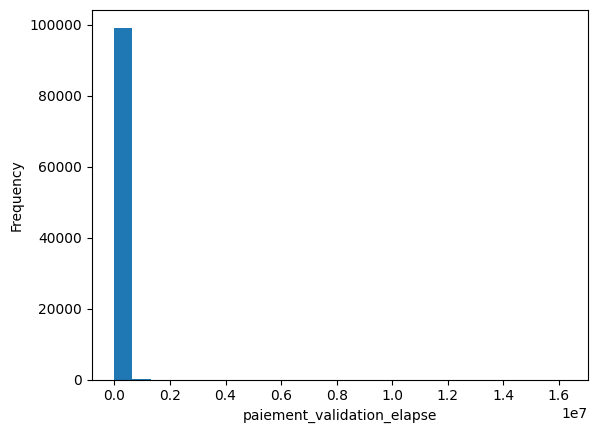

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : packaging_time_elapse
moyenne :  2 days 19:19:15.298850927
médiane :  1 days 19:38:29.500000
mode :  0   4 days 00:00:01
Name: packaging_time_elapse, dtype: timedelta64[ns]
min :  -172 days +18:44:38
max :  125 days 18:18:06
quartiles :  [numpy.timedelta64(76642000000000,'ns'), numpy.timedelta64(323096000000000,'ns')]
écart-type :  3 days 13:11:08.926729733


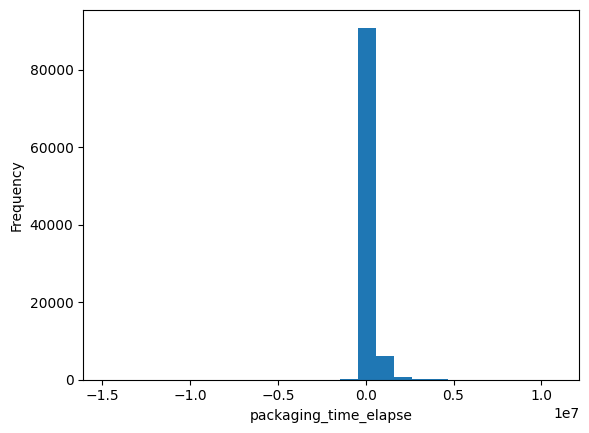

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : delivery_elapse_estimated
moyenne :  20 days 12:29:03.566241373
médiane :  20 days 06:42:02
mode :  0   21 days 09:40:00
Name: delivery_elapse_estimated, dtype: timedelta64[ns]
min :  -100 days +08:15:20
max :  192 days 10:25:00
quartiles :  [numpy.timedelta64(1301168000000000,'ns'), numpy.timedelta64(2261920000000000,'ns')]
écart-type :  8 days 18:27:07.875163968


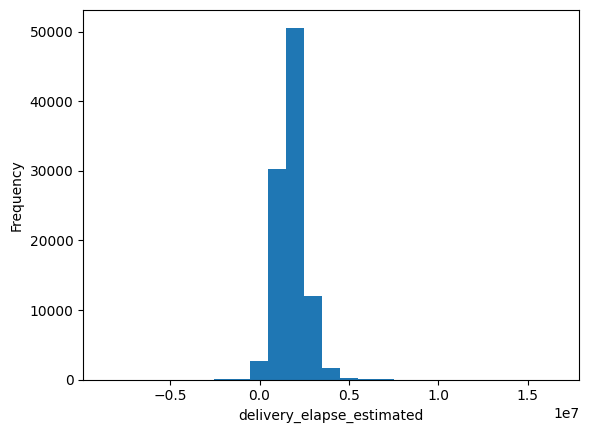

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : delivery_elapse_effective
moyenne :  9 days 07:55:59.254148743
médiane :  7 days 02:23:40
mode :  0   3 days
Name: delivery_elapse_effective, dtype: timedelta64[ns]
min :  -17 days +21:41:31
max :  205 days 04:35:00
quartiles :  [numpy.timedelta64(360393000000000,'ns'), numpy.timedelta64(1109756000000000,'ns')]
écart-type :  8 days 18:14:30.599411721


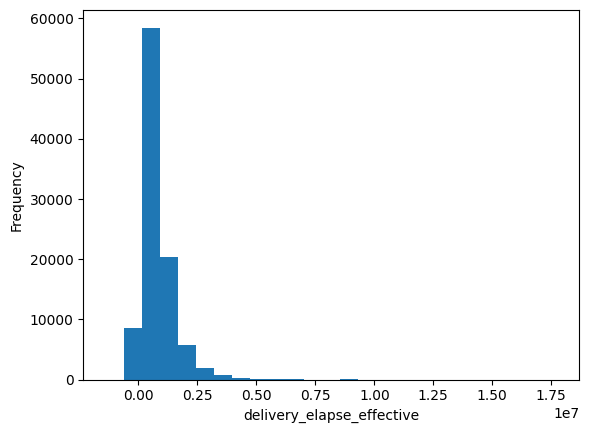

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : efficient_time_elapse
moyenne :  11 days 04:17:55.957616402
médiane :  11 days 22:46:28.500000
mode :  0   12 days 09:15:16
Name: efficient_time_elapse, dtype: timedelta64[ns]
min :  -189 days +00:35:53
max :  146 days 00:23:13
quartiles :  [numpy.timedelta64(578756000000000,'ns'), numpy.timedelta64(1476965000000000,'ns')]
écart-type :  10 days 04:27:55.620837417


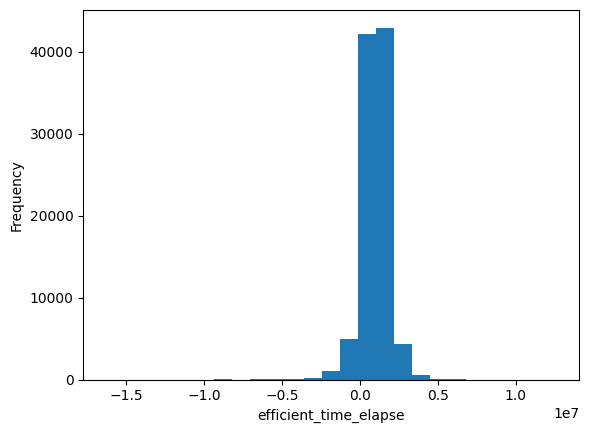

----------------------------------------------------------------------


In [33]:
plot_univarie_deltatime(data_orders, orders_col)

In [34]:
# data_customers_orders = data_customers.join(data_orders, how='left', on='customer_id')

In [35]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(data_orders.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df.head()
# missing_val_df["%"].hist(bins=20)
# plt.xlabel("Valeurs manquantes %")
# min_ylim, max_ylim = plt.ylim()
# plt.xticks(np.arange(0, 101, 10))
# plt.show()

,%
delivery_elapse_effective,2.9827
order_delivered_customer_date,2.9817
efficient_time_elapse,2.9817
packaging_time_elapse,1.8071
order_delivered_carrier_date,1.7930


# Test products

In [36]:
data_products = pd.read_csv("input/olist_products_dataset.csv", encoding='utf-8', sep=',')

In [37]:
data_products["product_volume_l"] = data_products["product_length_cm"] * data_products["product_height_cm"] * data_products["product_width_cm"] / 1000

In [38]:
data_products["product_density_kg_m3"] = data_products["product_weight_g"] / data_products["product_volume_l"]

In [39]:
data_products.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_l,product_density_kg_m3
count,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000,32949.000000,32949.000000
mean,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728,16.564097,203.689583
std,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047,27.057042,1009.270674
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,0.168000,0.000000
25%,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000,2.880000,66.176471
50%,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000,6.840000,116.550117
75%,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000,18.480000,195.868946
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,296.208000,85227.272727


In [76]:
mapping_names = pd.read_csv("product_category_name_translation.csv", encoding='utf-8', sep=',', index_col="product_category_name").to_dict()

In [82]:
data_products.replace({"product_category_name": mapping_names_dict['product_category_name_english']}, inplace=True)

## plot

In [40]:
def plot_univarie(df, list_col):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        # mesures de tendances centrales
        print("moyenne : ", df[col].mean())
        print("médiane : ", df[col].median())
        print("mode : ", df[col].mode())
        print("min : ", df[col].min())
        print("max : ", df[col].max())
        quartiles = [np.percentile(df[col], p) for p in [25, 75]]
        print("quartiles : ", quartiles)
        # mesures de dispersion
        print("variance : ", df[col].var(ddof=0))
        print("écart-type : ", df[col].std(ddof=0))
        print("coefficient de variation : ", df[col].std(ddof=0)/df[col].mean())
        # mesures de forme
        print("skewness : ", df[col].skew())
        print("kurtosis : ", df[col].kurtosis())
        df[col].hist(bins=25)
        plt.xlabel(col)
        # pour tracer les 1er et 3ème quartiles
        min_ylim, max_ylim = plt.ylim()
        # plt.xticks(np.arange(-15, 41, 5))
        plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
        plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
        plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
        df.boxplot(column=col, vert=False, showfliers=True)
        plt.show()
        print("-"*70)

In [41]:
def boxplot_univarie(df, list_col, showfliers=True):
    for col in list_col:
        print("-"*70)
        print("Colonne :", col)
        df.boxplot(column=col, vert=False, showfliers=showfliers)
        plt.show()
        print("-"*70)

In [42]:
data_num_prod, data_categ_prod = split_data_num_categ(data_products)

Voici la répartition des colonnes par type de données :
numeric : 9 colonnes.
category : 2 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


----------------------------------------------------------------------
Colonne : product_name_lenght
moyenne :  48.47694876472589
médiane :  51.0
mode :  0    60.0
Name: product_name_lenght, dtype: float64
min :  5.0
max :  76.0
quartiles :  [nan, nan]
variance :  104.97195712266483
écart-type :  10.245582322282361
coefficient de variation :  0.21134957094778065
skewness :  -0.903221758762539
kurtosis :  0.19256346035140837


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


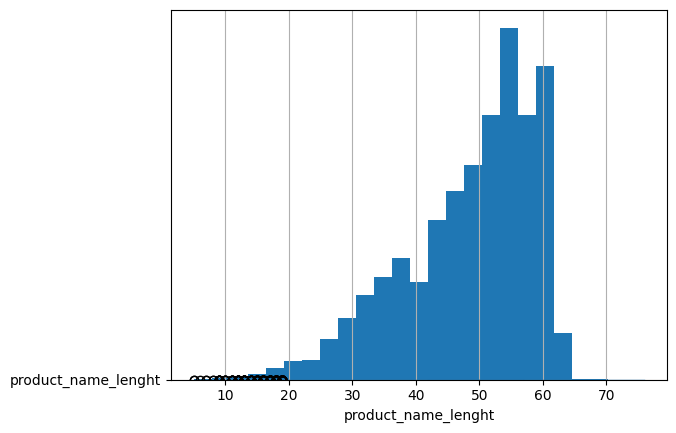

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_description_lenght
moyenne :  771.4952846232337
médiane :  595.0
mode :  0    404.0
Name: product_description_lenght, dtype: float64
min :  4.0
max :  3992.0
quartiles :  [nan, nan]
variance :  403358.87611795886
écart-type :  635.1054055178233
coefficient de variation :  0.8232135933636748
skewness :  1.962092763448352
kurtosis :  4.828922832039819


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


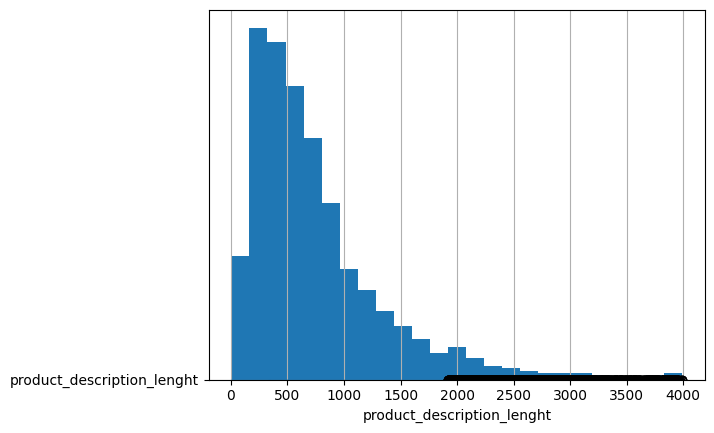

posx and posy should be finite values
posx and posy should be finite values


----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_photos_qty
moyenne :  2.1889861166939797
médiane :  1.0
mode :  0    1.0
Name: product_photos_qty, dtype: float64
min :  1.0
max :  20.0
quartiles :  [nan, nan]
variance :  3.016261613888451
écart-type :  1.736738786890087
coefficient de variation :  0.7933987217393043
skewness :  2.19340913301457
kurtosis :  7.263534231797978


posx and posy should be finite values
posx and posy should be finite values


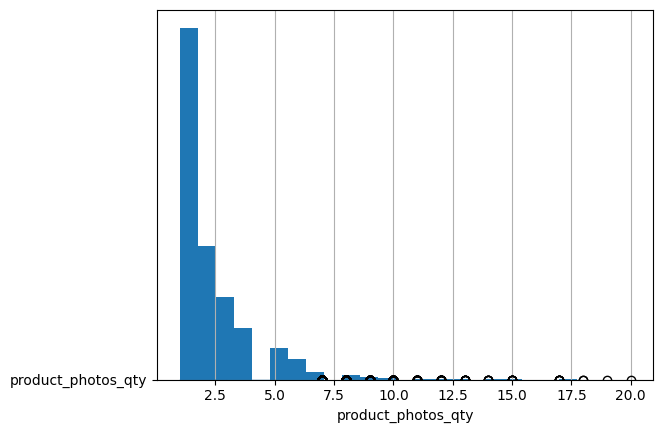

posx and posy should be finite values
posx and posy should be finite values


----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_volume_l
moyenne :  16.56409669489211
médiane :  6.84
mode :  0    8.0
Name: product_volume_l, dtype: float64
min :  0.168
max :  296.208
quartiles :  [nan, nan]
variance :  732.0612841805801
écart-type :  27.05663105747979
coefficient de variation :  1.633450441388891
skewness :  4.176053645475027
kurtosis :  24.620790703411178


posx and posy should be finite values
posx and posy should be finite values


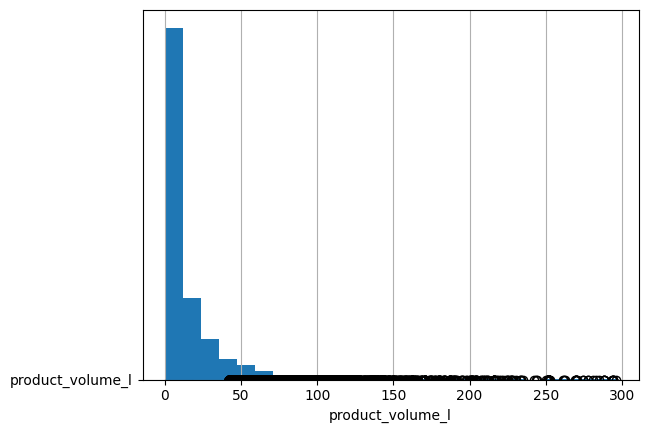

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_density_kg_m3
moyenne :  203.68958257514586
médiane :  116.55011655011656
mode :  0    568.181818
Name: product_density_kg_m3, dtype: float64
min :  0.0
max :  85227.27272727274
quartiles :  [nan, nan]
variance :  1018596.3776934915
écart-type :  1009.2553580207001
coefficient de variation :  4.954869784017364
skewness :  50.30857673241881
kurtosis :  3173.680781777347


posx and posy should be finite values


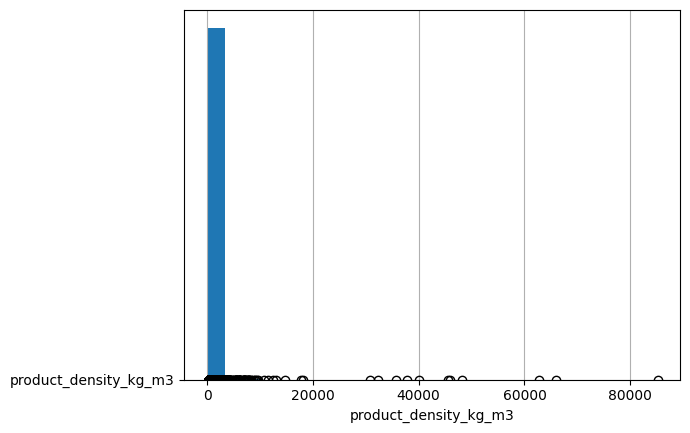

----------------------------------------------------------------------


In [43]:
data_num_prod_select = [x for x in data_num_prod if x not in ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]
plot_univarie(data_products, data_num_prod_select)

## boxplot

----------------------------------------------------------------------
Colonne : product_name_lenght


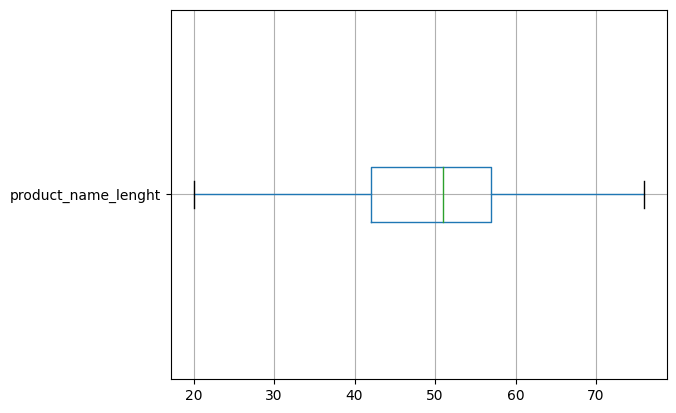

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_description_lenght


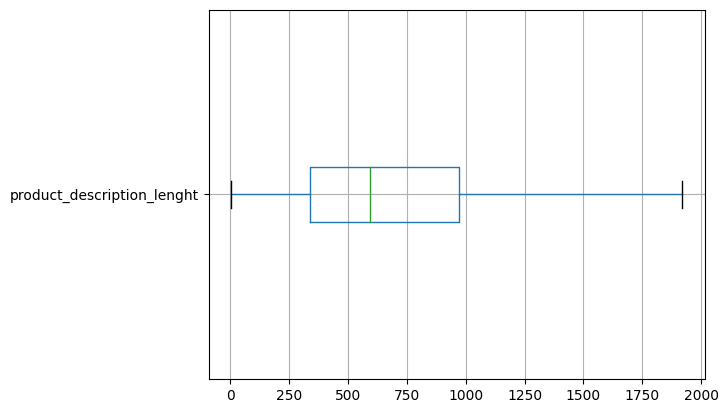

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_photos_qty


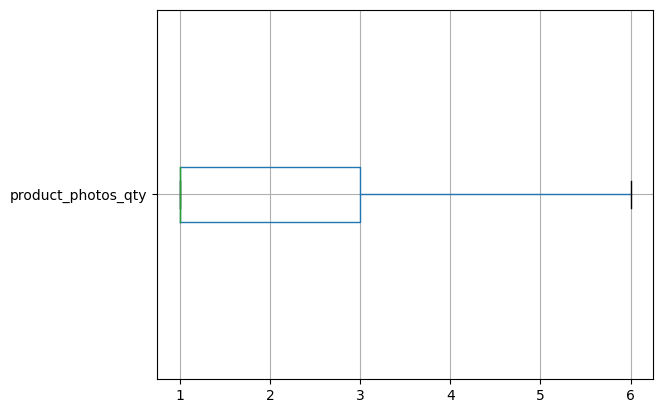

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_volume_l


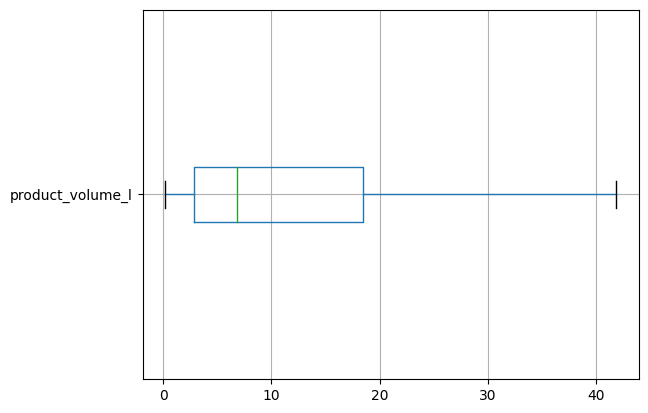

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : product_density_kg_m3


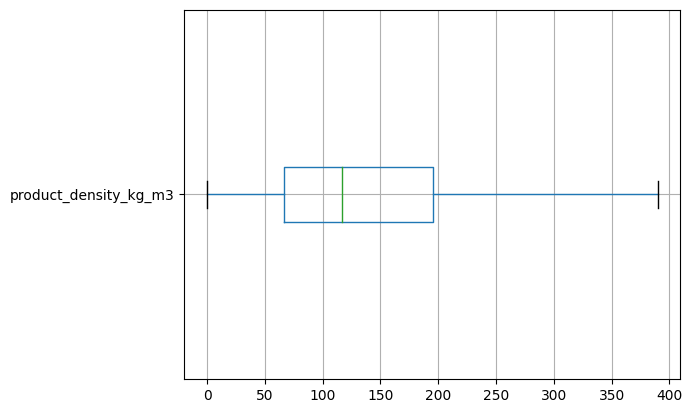

----------------------------------------------------------------------


In [44]:
boxplot_univarie(data_products, data_num_prod_select, showfliers=False)

## pie chart

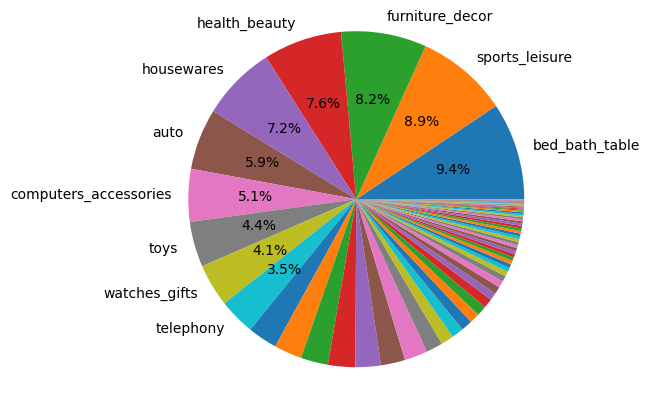

In [85]:
limit_perc = 3
temp_val_count = data_products["product_category_name"].value_counts(normalize=True)
temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.axis('equal')
plt.show()

# Test reviews

In [45]:
data_reviews = pd.read_csv("input/olist_order_reviews_dataset.csv", encoding='utf-8', sep=',', parse_dates=["review_answer_timestamp", "review_creation_date"])

In [46]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB


----------------------------------------------------------------------
Colonne : review_score
moyenne :  4.08642062404257
médiane :  5.0
mode :  0    5
Name: review_score, dtype: int64
min :  1
max :  5
quartiles :  [4.0, 5.0]
variance :  1.8159512129004571
écart-type :  1.3475723405073499
coefficient de variation :  0.32976838766397915
skewness :  -1.3643857064388185
kurtosis :  0.5076529138145442


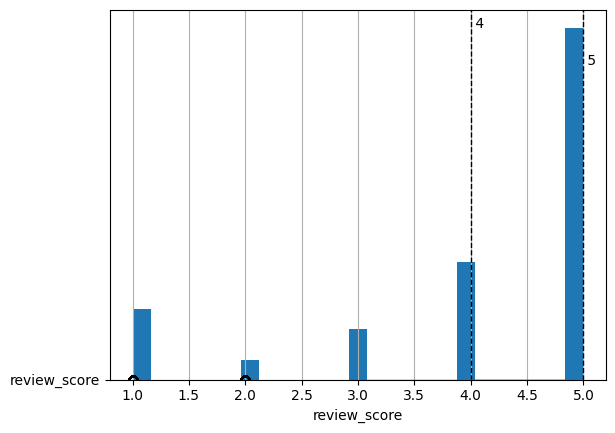

----------------------------------------------------------------------


In [86]:
plot_univarie(data_reviews, ["review_score"])

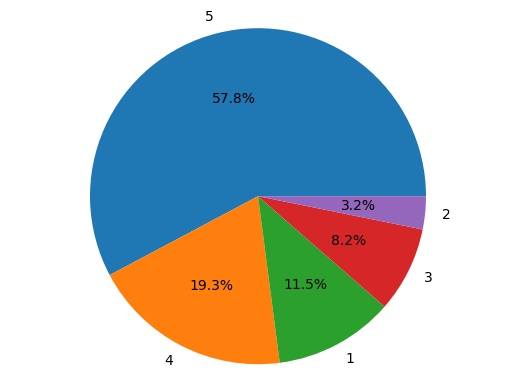

In [87]:
limit_perc = 3
temp_val_count = data_reviews["review_score"].value_counts(normalize=True)
temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.axis('equal')
plt.show()

In [48]:
# plot_univarie_deltatime(data_reviews, ["review_answer_timestamp", "review_creation_date"])

----------------------------------------------------------------------
Colonne : review_score


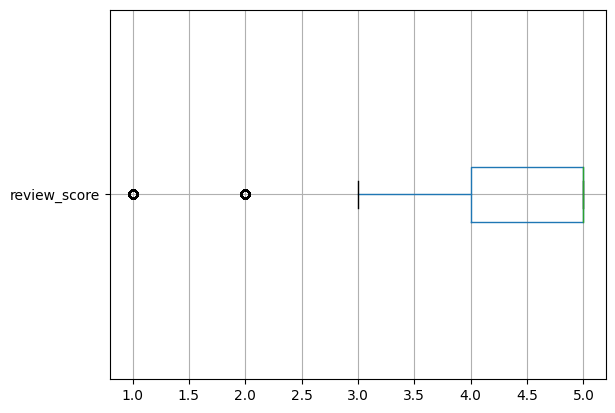

----------------------------------------------------------------------


In [49]:
boxplot_univarie(data_reviews, ["review_score"], showfliers=True)

In [50]:
data_reviews["reaction_elapse"] = data_reviews["review_answer_timestamp"] - data_reviews["review_creation_date"]

In [51]:
data_reviews.describe()

,review_score,reaction_elapse
count,99224.000000,99224
mean,4.086421,3 days 03:34:33.029700475
std,1.347579,9 days 21:21:40.258026234
min,1.000000,0 days 02:08:29
25%,4.000000,1 days 00:07:00.750000
50%,5.000000,1 days 16:11:55.500000
75%,5.000000,3 days 02:29:08
max,5.000000,518 days 16:46:52


----------------------------------------------------------------------
Colonne : reaction_elapse
moyenne :  3 days 03:34:33.029700475
médiane :  1 days 16:11:55.500000
mode :  0   1 days 00:44:33
Name: reaction_elapse, dtype: timedelta64[ns]
min :  0 days 02:08:29
max :  518 days 16:46:52
quartiles :  [numpy.timedelta64(86820750000000,'ns'), numpy.timedelta64(268148000000000,'ns')]
écart-type :  9 days 21:21:35.952100193


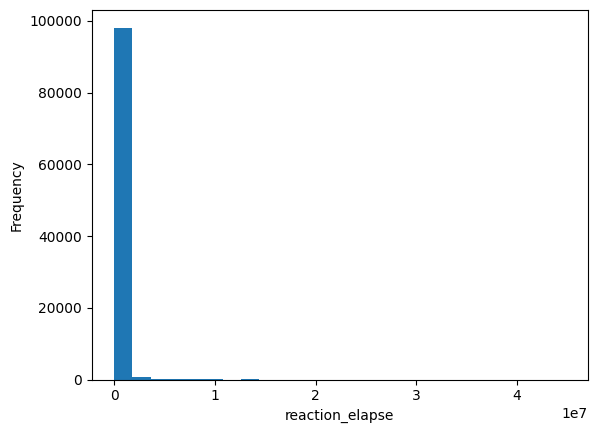

----------------------------------------------------------------------


In [52]:
plot_univarie_deltatime(data_reviews, ["reaction_elapse"])

## Word plot

In [53]:
import matplotlib.pyplot as plt
def Plot_world(text):
    comment_words = ' '
    for val in text: 

        # typecaste each val to string 
        val = str(val) 
        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='white', 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

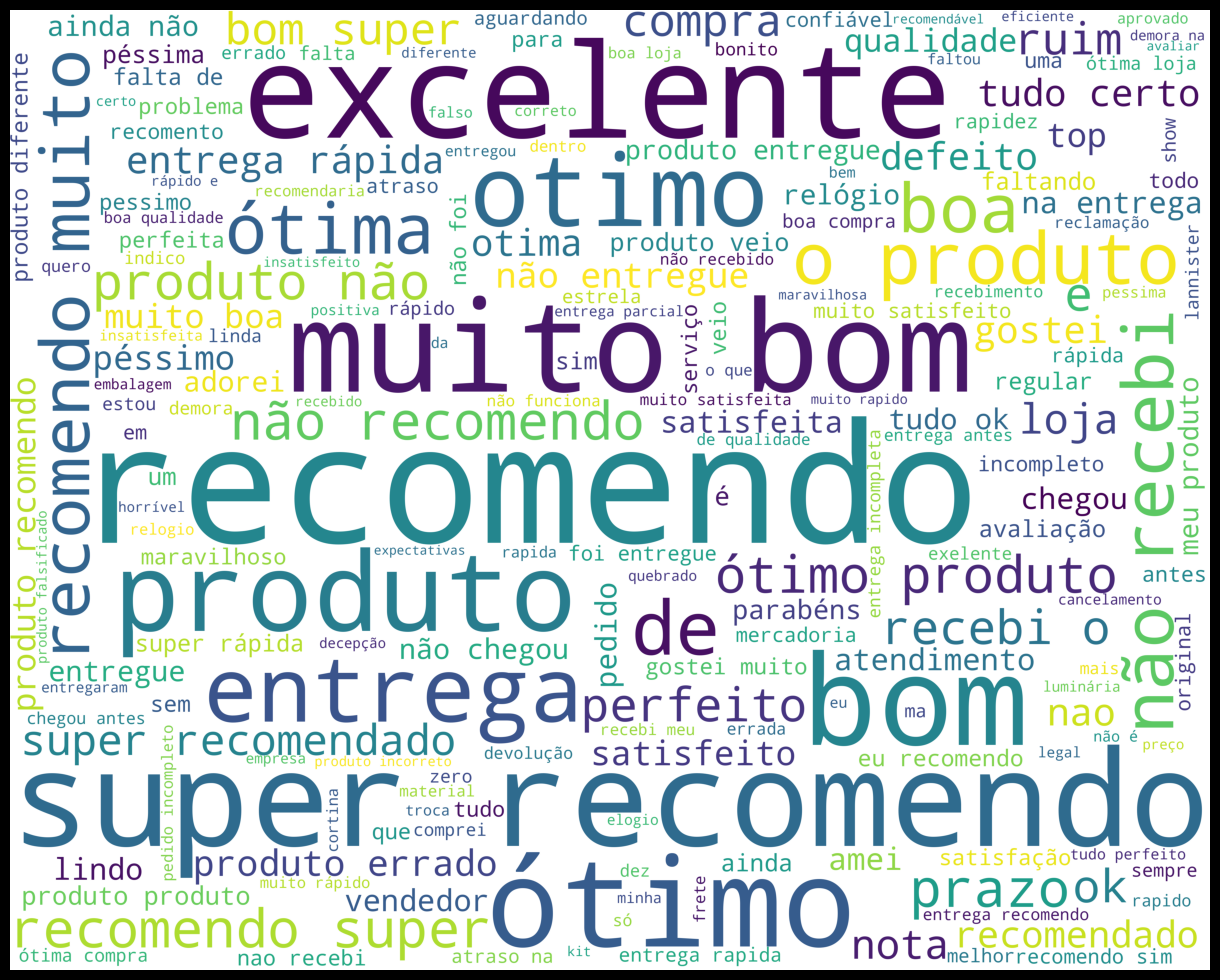

In [54]:
from wordcloud import WordCloud
sub_data = data_reviews.loc[data_reviews["review_comment_title"].notnull(), :]
text = sub_data["review_comment_title"].values
Plot_world(text)

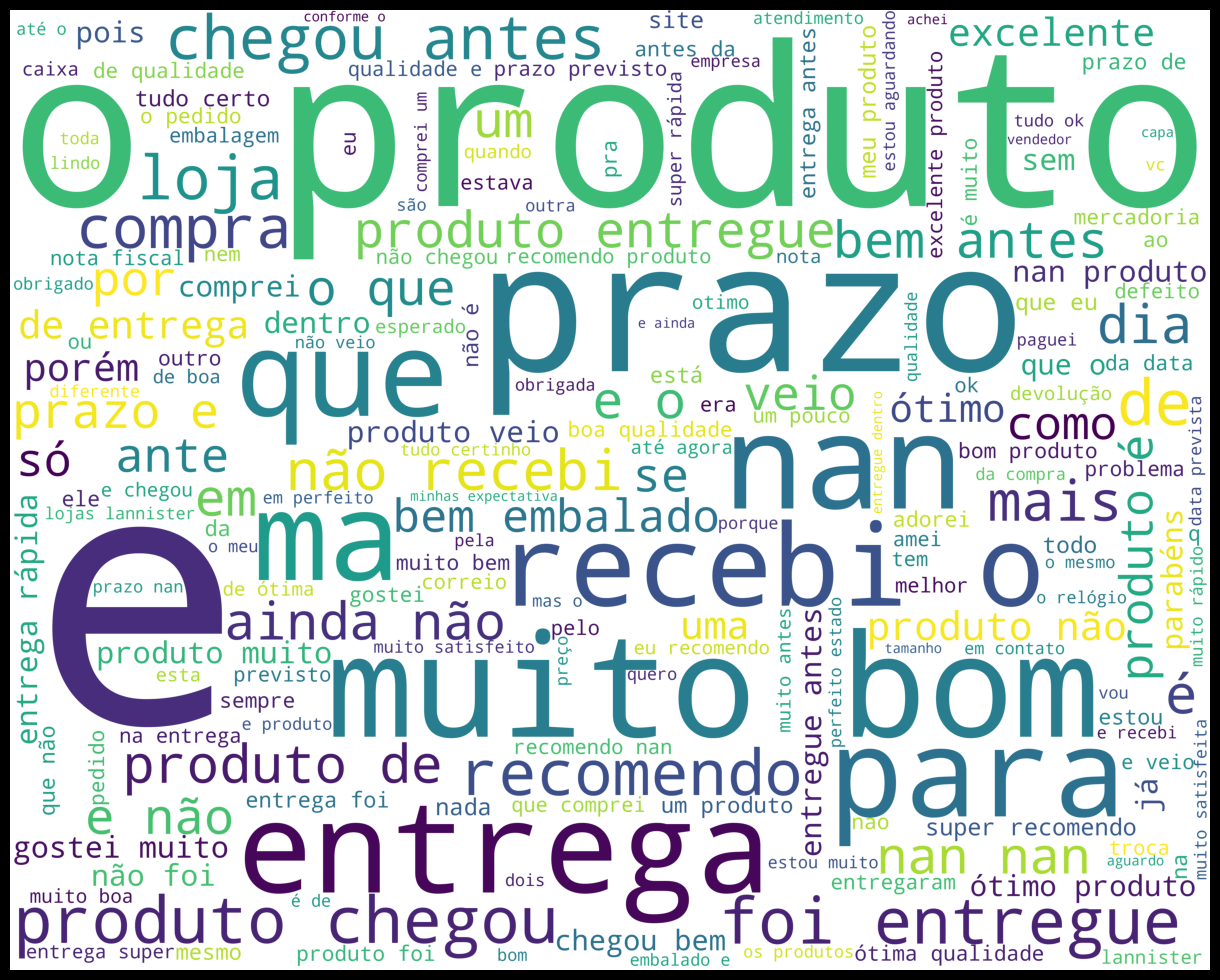

In [55]:
sub_data_message = data_reviews.loc[data_reviews["review_comment_message"].notnull(), :]
text = sub_data["review_comment_message"].values
Plot_world(text)

# Test payments

In [56]:
data_payments = pd.read_csv("input/olist_order_payments_dataset.csv", encoding='utf-8', sep=',')

In [57]:
data_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


----------------------------------------------------------------------
Colonne : payment_sequential
moyenne :  1.0926785129853878
médiane :  1.0
mode :  0    1
Name: payment_sequential, dtype: int64
min :  1
max :  29
quartiles :  [1.0, 1.0]
variance :  0.49925583117048195
écart-type :  0.7065803784216499
coefficient de variation :  0.6466498334365058
skewness :  16.1800647173527
kurtosis :  370.5938087869398


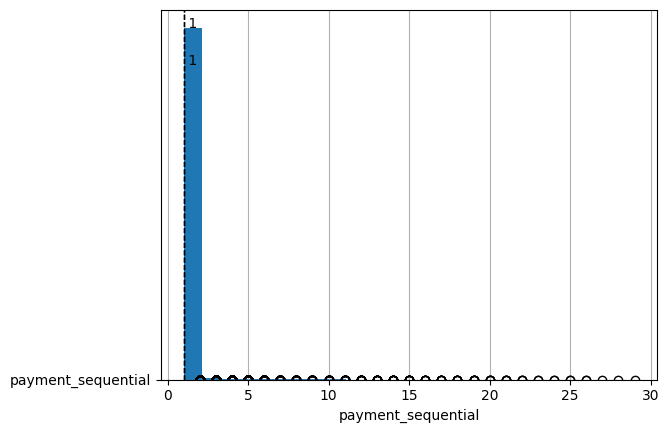

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : payment_installments
moyenne :  2.853348863176944
médiane :  1.0
mode :  0    1
Name: payment_installments, dtype: int64
min :  0
max :  24
quartiles :  [1.0, 4.0]
variance :  7.22017182229079
écart-type :  2.6870377411362854
coefficient de variation :  0.9417137090431044
skewness :  1.6550737635551802
kurtosis :  2.5500479292629437


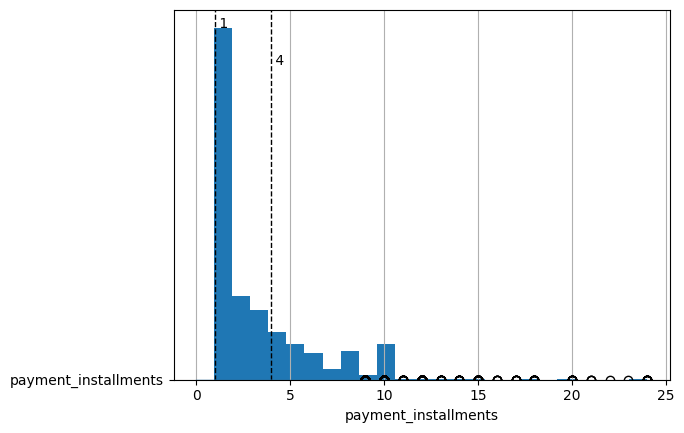

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : payment_value
moyenne :  154.10038041699553
médiane :  100.0
mode :  0    50.0
Name: payment_value, dtype: float64
min :  0.0
max :  13664.08
quartiles :  [56.79, 171.8375]
variance :  47303.21247430804
écart-type :  217.49301707022238
coefficient de variation :  1.4113723566527636
skewness :  9.254009528478063
kurtosis :  241.8284419145052


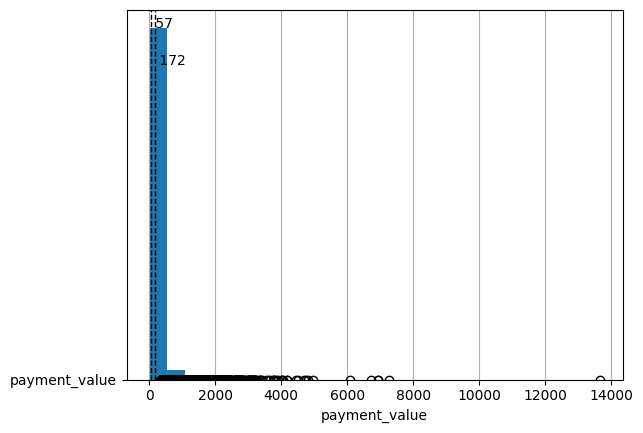

----------------------------------------------------------------------


In [58]:
plot_univarie(data_payments, ["payment_sequential", "payment_installments", "payment_value"])

----------------------------------------------------------------------
Colonne : payment_sequential


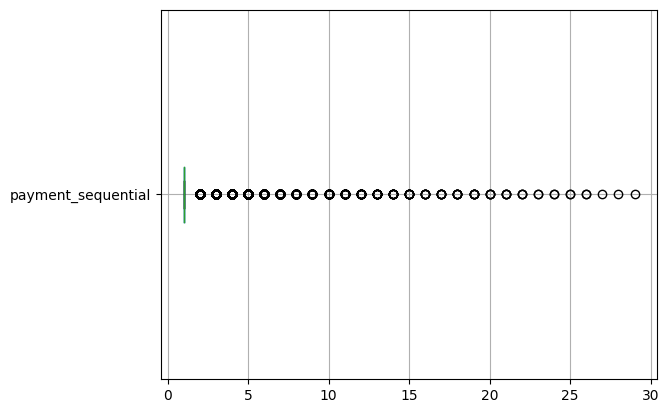

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : payment_installments


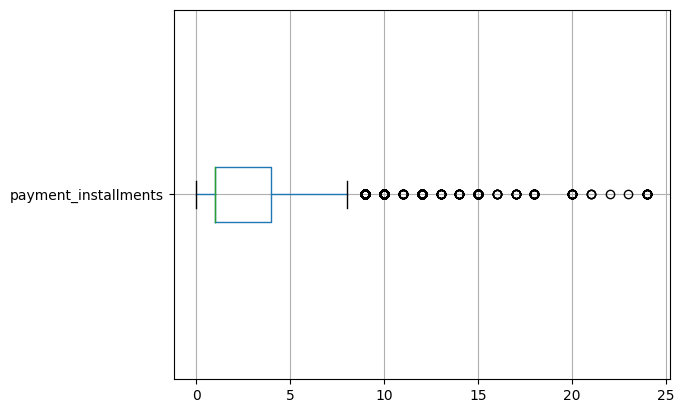

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : payment_value


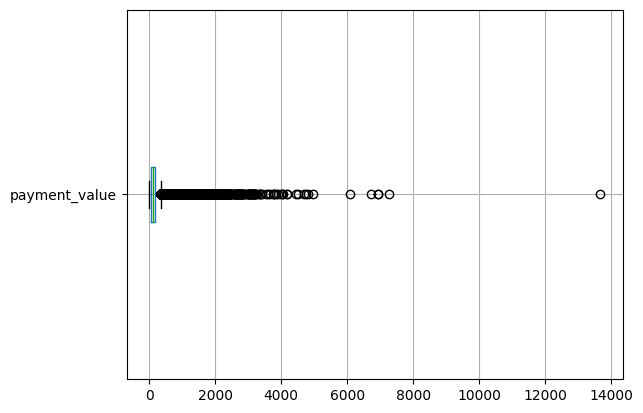

----------------------------------------------------------------------


In [59]:
boxplot_univarie(data_payments, ["payment_sequential", "payment_installments", "payment_value"])

In [60]:
data_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [61]:
sub_pay = data_payments.loc[data_payments["order_id"] == '98f0e2b0d85754ca3b4e06d70f0f63a2', :]
sub_pay.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
949,98f0e2b0d85754ca3b4e06d70f0f63a2,2,credit_card,2,70.0
9112,98f0e2b0d85754ca3b4e06d70f0f63a2,1,credit_card,2,42.2


In [62]:
sub_seq = data_payments.loc[(data_payments["payment_sequential"] > 1) & (data_payments["payment_installments"] > 1), :]
sub_seq.head(20)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
199,332c6742772f2df936696b6512b10edb,2,credit_card,6,134.55
949,98f0e2b0d85754ca3b4e06d70f0f63a2,2,credit_card,2,70.00
2191,510bff1cf06be1143d3b6698df2fd486,2,credit_card,8,406.38
2231,1590f37cad06b14cb123f6a45b2bdf4c,2,credit_card,5,53.65
2632,253bf86c38be4d6ffa40eb641a356d69,2,credit_card,3,31.68
2660,9c781d427857ca8dee49b22614eb9e39,2,credit_card,3,742.51
3272,cfa1591318ed6c901b0c80debfd4b811,2,credit_card,10,330.11
4106,afd71840756746edd2c71bd69b2e904e,2,credit_card,2,21.68
4429,9769f28d910e7304d7bf0fcd32d8ecd6,2,credit_card,4,339.54
4575,29f4481c82fe8804ae3de770fd4012aa,2,credit_card,3,113.70


# Test order items

In [63]:
data_order_items = pd.read_csv("input/olist_order_items_dataset.csv", encoding='utf-8', sep=',')

In [64]:
data_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


----------------------------------------------------------------------
Colonne : price
moyenne :  120.65373901464716
médiane :  74.99
mode :  0    59.9
Name: price, dtype: float64
min :  0.85
max :  6735.0
quartiles :  [39.9, 134.9]
variance :  33721.12018434555
écart-type :  183.63311298441124
coefficient de variation :  1.5219844364882757
skewness :  7.92320826321351
kurtosis :  120.82829811136266


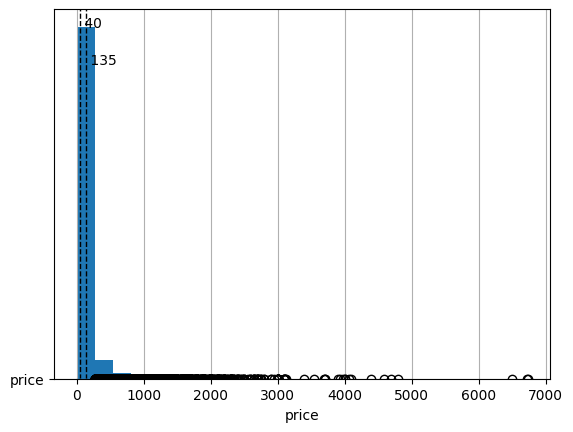

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : freight_value
moyenne :  19.990319928983578
médiane :  16.26
mode :  0    15.1
Name: freight_value, dtype: float64
min :  0.0
max :  409.68
quartiles :  [13.08, 21.15]
variance :  249.8402341932513
écart-type :  15.806335254993527
coefficient de variation :  0.7906994640979321
skewness :  5.639869620428684
kurtosis :  59.78825261835198


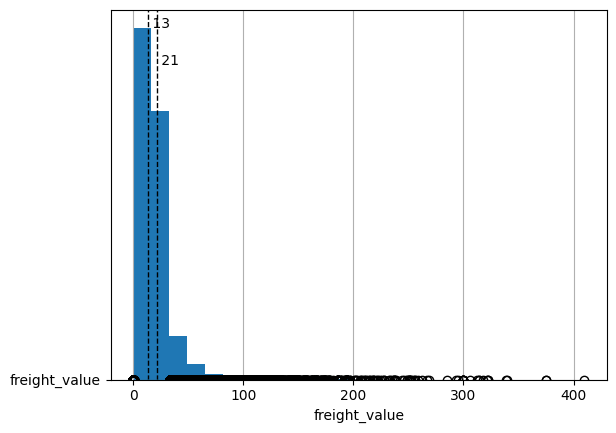

----------------------------------------------------------------------


In [65]:
plot_univarie(data_order_items, ["price", "freight_value"])

----------------------------------------------------------------------
Colonne : price


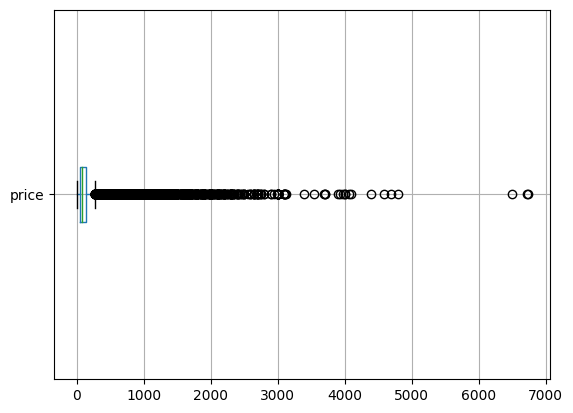

----------------------------------------------------------------------
----------------------------------------------------------------------
Colonne : freight_value


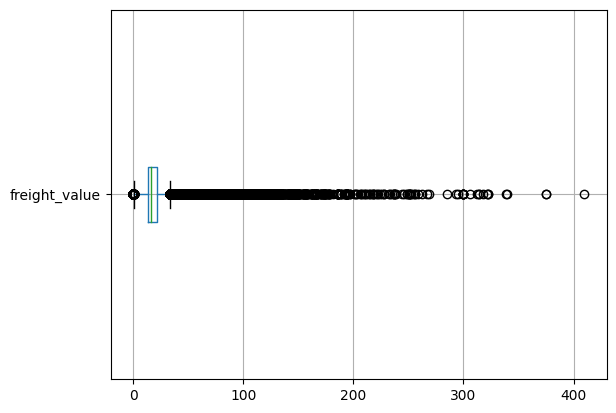

----------------------------------------------------------------------


In [71]:
boxplot_univarie(data_order_items, ["price", "freight_value"])

In [66]:
sub_items = data_order_items.loc[data_order_items["order_item_id"] > 2, :]
sub_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
139,00526a9d4ebde463baee25f386963ddc,3,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.40
140,00526a9d4ebde463baee25f386963ddc,4,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.40
153,005d9a5423d47281ac463a968b3936fb,3,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,24.99,13.58


In [67]:
sub_item_2 = data_order_items.loc[data_order_items["order_id"] == '00526a9d4ebde463baee25f386963ddc', :]
sub_item_2.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
137,00526a9d4ebde463baee25f386963ddc,1,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.4
138,00526a9d4ebde463baee25f386963ddc,2,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.4
139,00526a9d4ebde463baee25f386963ddc,3,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.4
140,00526a9d4ebde463baee25f386963ddc,4,0c4a0f8ab44f9acd2d04e7024f9ba362,7210cd29727d674c00741e5e387b3ccd,2018-08-14 22:15:22,33.89,8.4


In [68]:
truc = data_orders.loc[data_orders["order_id"] == '00526a9d4ebde463baee25f386963ddc', :]
truc.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paiement_validation_elapse,packaging_time_elapse,delivery_elapse_estimated,delivery_elapse_effective,efficient_time_elapse
19332,00526a9d4ebde463baee25f386963ddc,5848ef3f994e18c5121d291e0daedc81,delivered,2018-08-07 22:03:44,2018-08-07 22:15:22,2018-08-08 14:11:00,2018-08-16 19:58:24,2018-08-15,0 days 00:11:38,0 days 15:55:38,6 days 09:49:00,8 days 05:47:24,-2 days +04:01:36


In [69]:
bidule = data_products.loc[data_products["product_id"] == '0c4a0f8ab44f9acd2d04e7024f9ba362', :]
bidule.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_l,product_density_kg_m3
9224,0c4a0f8ab44f9acd2d04e7024f9ba362,alimentos,49.0,740.0,1.0,388.0,16.0,16.0,14.0,3.584,108.258929


In [70]:
chouette = data_payments.loc[data_payments["order_id"] == '00526a9d4ebde463baee25f386963ddc', :]
chouette.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51463,00526a9d4ebde463baee25f386963ddc,1,credit_card,3,169.16
